In [1]:
from Genome.goldstandard_pair.lls import *
gd = '/home/hermuba/data0118/goldstandard/tf_intersect_GO_rm_plasmidGO.smpl'
gold = read_gold(gd)

In [2]:
import pandas as pd
eskape = pd.read_csv('~/data0118/joined_smpl/eskape_GO_smpl_rm_plasmid')
refseq = pd.read_csv('~/data0118/joined_smpl/refseq_GO_smpl_rm_plasmid')
domain = pd.read_csv('~/data0118/joined_smpl/domain_GO_smpl_rm_plasmid')
string = pd.read_csv('~/data0118/joined_smpl/string_GO_smpl_rm_plasmid')

In [3]:
eskape.shape

(999802, 6)

In [4]:
refseq.shape

(995879, 6)

In [5]:
# calculate LLS score for 250 bins
import numpy as np
def fitting_LLS(all_chunk, bins = 250, lls_function = lls_for_other, score = 'mutual_info'):

    
    lls_score = lls_function(all_chunk, score, bins = bins)

    # do OLD METHOD: linear regression when LLS > threshold; try different inflection point
    linear = {}
    linear_mse = {}
    for lls_thres in [0,1,2,3]:
        try:
            true_thres, slope, intercept = lls_regress_thres(lls_score, lls_thres = lls_thres)
            linear_lls = map_lls(lls_score, true_thres, slope, intercept)
            linear[lls_thres] = linear_lls
    
            # calculate MSE
            mse = np.sum((linear_lls.values - lls_score.values)**2) # we only care about data points with good signal
            linear_mse[lls_thres] = mse
        except:
            print('no bin has LLS greater than {}'.format(lls_thres))


    # new method, exponential
    subset = lls_score.copy()

    # exp can't have <=0 zero values
    smallest_nonneg = subset[subset>0].min()
    subset.loc[subset<0] = smallest_nonneg
    y = subset.values
    x = np.array(range(len(y)))

    # Try different params
    expo_curves = {}
    expo_mse = {}
    
    from math import ceil
    for top_bins in range(0, bins, ceil(bins/10)):
        expo_param = np.polyfit(x[-top_bins:], np.log(y[-top_bins:]), 1) #y = Ae*bx
        fitted = np.exp(expo_param[1]) * np.exp(expo_param[0]*np.array(x))
        expo_curves[top_bins]=fitted
    
        mse = np.sum((fitted - lls_score.values)**2)
        expo_mse[top_bins] = mse
    return lls_score, linear, linear_mse, expo_curves, expo_mse



# Exploring Hyperparameters

Text(0.5, 1.0, 'Curve Fitting for ESKAPE')

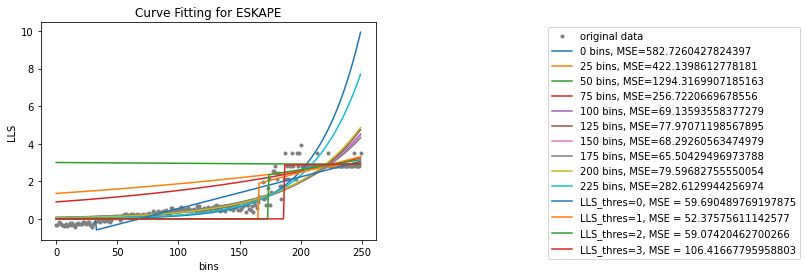

In [6]:
lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(eskape, bins =250)
import matplotlib.pyplot as plt
plt.plot(lls_score, '.', label = 'original data', color = 'grey')
for top_bins in expo_curves.keys():
    plt.plot(expo_curves[top_bins], label = '{} bins, MSE={}'.format(top_bins, expo_mse[top_bins]))
for t in linear.keys():
    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
#plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
plt.ylabel('LLS')
plt.xlabel('bins')

plt.legend(bbox_to_anchor = (1.5, 1))
plt.title('Curve Fitting for ESKAPE')



Text(0.5, 1.0, 'Curve Fitting for REFSEQ')

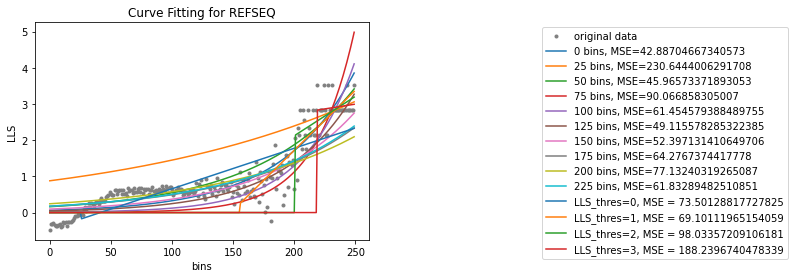

In [7]:
lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(refseq)
import matplotlib.pyplot as plt
plt.plot(lls_score, '.', label = 'original data', color = 'grey')
for top_bins in expo_curves.keys():
    plt.plot(expo_curves[top_bins], label = '{} bins, MSE={}'.format(top_bins, expo_mse[top_bins]))
for t in linear.keys():
    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
#plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
plt.ylabel('LLS')
plt.xlabel('bins')

plt.legend(bbox_to_anchor = (1.5, 1))
plt.title('Curve Fitting for REFSEQ')



In [ ]:
lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(refseq, score = 'nrm_mutual')
import matplotlib.pyplot as plt
plt.plot(lls_score, '.', label = 'original data', color = 'grey')
for top_bins in expo_curves.keys():
    plt.plot(expo_curves[top_bins], label = '{} bins, MSE={}'.format(top_bins, expo_mse[top_bins]))
for t in linear.keys():
    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
#plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
plt.ylabel('LLS')
plt.xlabel('bins')

plt.legend(bbox_to_anchor = (1.5, 1))
plt.title('Curve Fitting for REFSEQ')



/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 1.0, 'Curve Fitting for DOMAIN')

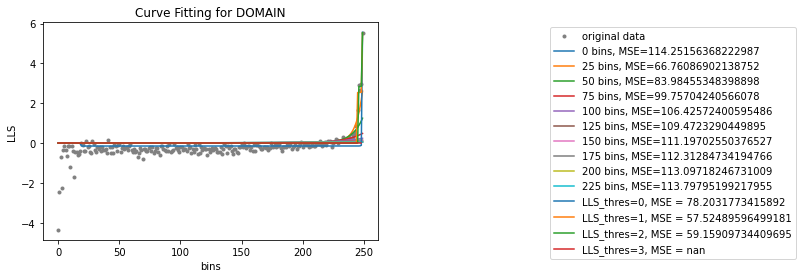

In [24]:
lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(domain, lls_function = lls_for_domain, score = 'weighted_mutual', bins = 250)
import matplotlib.pyplot as plt
plt.plot(lls_score, '.', label = 'original data', color = 'grey')
for top_bins in expo_curves.keys():
    plt.plot(expo_curves[top_bins], label = '{} bins, MSE={}'.format(top_bins, expo_mse[top_bins]))
for t in linear.keys():
    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
#plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
plt.ylabel('LLS')
plt.xlabel('bins')

plt.legend(bbox_to_anchor = (1.5, 1))
plt.title('Curve Fitting for DOMAIN')



no bin has LLS greater than 3


/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 1.0, 'Curve Fitting for STRING')

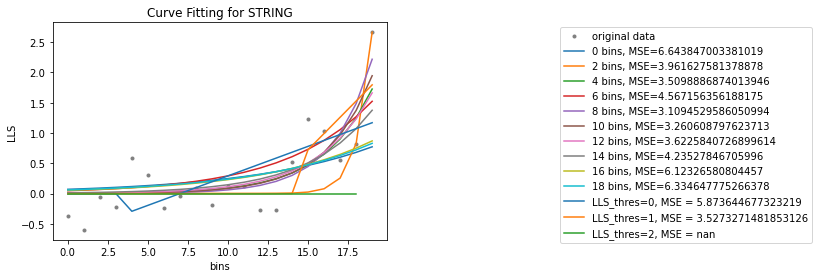

In [9]:
lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(string, bins = 20, score = 'combined_score')
import matplotlib.pyplot as plt
plt.plot(lls_score, '.', label = 'original data', color = 'grey')
for top_bins in expo_curves.keys():
    plt.plot(expo_curves[top_bins], label = '{} bins, MSE={}'.format(top_bins, expo_mse[top_bins]))
for t in linear.keys():
    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
#plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
plt.ylabel('LLS')
plt.xlabel('bins')

plt.legend(bbox_to_anchor = (1.5, 1))
plt.title('Curve Fitting for STRING')



# Mapping the hyperparameters to network

In [10]:
def fitting_LLS_exp(all_chunk, bins = 250, lls_function = lls_for_other, score = 'mutual_info', top_bins = 175):

    
    lls_score = lls_function(all_chunk, score, bins = bins)

    # new method, exponential
    subset = lls_score.copy()

    # exp can't have <=0 zero values
    smallest_nonneg = subset[subset>0].min()
    subset.loc[subset<0] = smallest_nonneg
    y = subset.values
    x = np.array(range(len(y)))

    
    
    
    expo_param = np.polyfit(x[-top_bins:], np.log(y[-top_bins:]), 1) #y = Ae*bx
    fitted = np.exp(expo_param[1]) * np.exp(expo_param[0]*np.array(x))
    
    fitted_lls = pd.Series(fitted, index = lls_score.index)
    return fitted_lls


In [12]:
%load_ext autoreload

%autoreload 2
from Genome.goldstandard_pair.lls import *

In [ ]:
new_lls = fitting_LLS_exp(eskape, bins = 250, lls_function = lls_for_other, score = 'mutual_info', top_bins = 175)
net = '/home/hermuba/data0118/mutual_info/eskape_blastp_out_max_evalue_pivot_new_ordinary40_mutual' 
output = '/home/hermuba/data0118/network1122/eskape_lls_rm_plasmid_edgelist'
# map LLS_reg back to each "whole" network
map_lls_to_whole_data(net, new_lls, 'mutual_info', output, 'eskape', lls_thres = 1) # use mutual info

at 0 chunk, we have 73 edges with lls > 1


/home/hermuba/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


at 100 chunk, we have 6643 edges with lls > 1
at 200 chunk, we have 12909 edges with lls > 1
at 300 chunk, we have 19530 edges with lls > 1
at 400 chunk, we have 25856 edges with lls > 1
at 500 chunk, we have 30545 edges with lls > 1
at 600 chunk, we have 36648 edges with lls > 1
at 700 chunk, we have 45815 edges with lls > 1
at 800 chunk, we have 53825 edges with lls > 1
at 900 chunk, we have 65187 edges with lls > 1
at 1000 chunk, we have 70445 edges with lls > 1


In [ ]:
new_lls = fitting_LLS_exp(domain, bins = 250, lls_function = lls_for_domain, score = 'weighted_mutual', top_bins = 25)
net = '/home/hermuba/data0118/domain/domain_rm_plasmid_weighted_mutual'
output = '/home/hermuba/data0118/network1122/domain_lls_rm_plasmid_edgelist'
# map LLS_reg back to each "whole" network
map_lls_to_whole_data(net, new_lls, 'weighted_mutual', output, 'domain', lls_thres = 1) # use mutual info

at 0 chunk, we have 1234 edges with lls > 1


/home/hermuba/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


at 100 chunk, we have 114402 edges with lls > 1
at 200 chunk, we have 226619 edges with lls > 1
at 300 chunk, we have 332565 edges with lls > 1
at 400 chunk, we have 438615 edges with lls > 1
at 500 chunk, we have 537623 edges with lls > 1
at 600 chunk, we have 640124 edges with lls > 1
at 700 chunk, we have 745350 edges with lls > 1
at 800 chunk, we have 857443 edges with lls > 1
at 900 chunk, we have 973133 edges with lls > 1
at 1000 chunk, we have 1081251 edges with lls > 1
at 1100 chunk, we have 1191076 edges with lls > 1
at 1200 chunk, we have 1305822 edges with lls > 1
at 1300 chunk, we have 1410829 edges with lls > 1


In [ ]:
new_lls = fitting_LLS_exp(refseq, bins = 250, lls_function = lls_for_other, score = 'nrm_mutual', top_bins = 0)
net = '/home/hermuba/data0118/mutual_info/blastp_out_max_evalue_pivot_new_ordinary40_mutual'
output = '/home/hermuba/data0118/network1122/refseq_lls_rm_plasmid_edgelist'
# map LLS_reg back to each "whole" network
map_lls_to_whole_data(net, new_lls, 'nrm_mutual', output, 'refseq', lls_thres = 1) # use mutual info